# AB-test



In [2]:
#импортруем необхожимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandahouse
from scipy import stats

sns.set()

In [3]:
#подключение к бд
connection = {
'host': 'https://clickhouse.lab.karpov.courses',
'password': 'password',
'user': 'student',
'database': 'simulator_20220420'
}

In [4]:
#формируем запрос
q = '''SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-04-04' and '2022-04-10'
    and exp_group in (2,1)
GROUP BY exp_group, user_id'''
df = pandahouse.read_clickhouse(q, connection=connection)

In [5]:
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [6]:
#в обоих группах почти равное количество пользователей - десять тысяч
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


Проведем тесты.

Наша нулевая гипотеза звучит так: CTR контрольной и экспериментальной группы не различаются.

Соответсвенно альтернативная гипотеза: CTR контрольной и экспериментальной группы различаются.

T-test

In [7]:
stats.ttest_ind(df.query('exp_group == 2')['ctr'],
                df.query('exp_group == 1')['ctr'],
                equal_var=False)

Ttest_indResult(statistic=-0.7094392041270486, pvalue=0.4780623130874935)

t-test показывет, что статистически значимых различий в двух группах нет, т.е. нет оснований отклонить нашу нулевую гипотезу о равенстве средних ctr в двух группах.

Mann–Whitney

In [8]:
stats.mannwhitneyu(df.query('exp_group == 2')['ctr'],
                   df.query('exp_group == 1')['ctr'],
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=43704947.5, pvalue=6.0376484617779035e-56)

Тест Манна-Уитни же говорит о том, что средние различны

Пуассоновский бутстреп

In [9]:
#функция бутстрепа
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [10]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [11]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

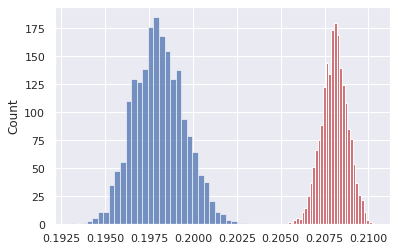

In [12]:
sns.histplot(ctr1, color='r')
sns.histplot(ctr2);

Бутстреп показывает что в одной группе групповой ctr выше, чем в другой, а точнее в группе 1, т.е. в контрольной.

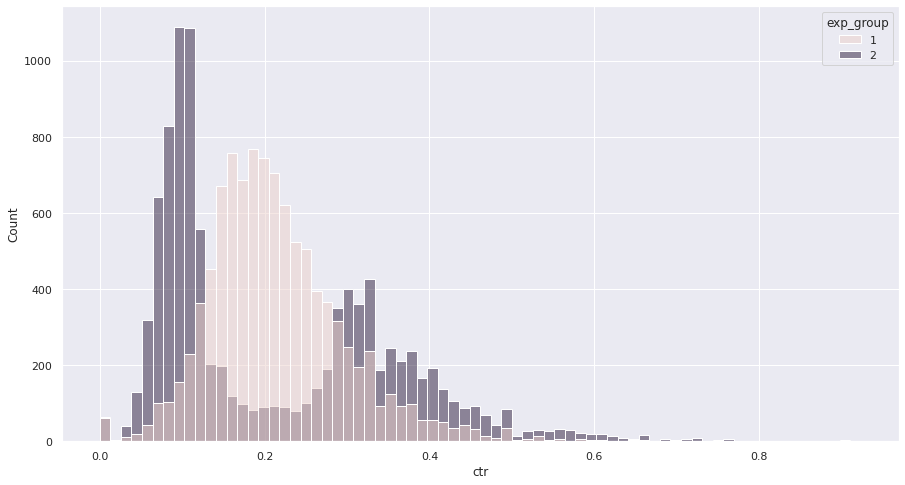

In [13]:
#посмотрим на распределение ctr на графике.
plt.figure(figsize=(15,8))
sns.histplot(data=df, x='ctr', hue='exp_group');

Как видно на графике, в отличии от контрольной группы, распределение ctr которой выглядит нормальным, у эксперементальной группы распределение двухмодально.

In [14]:
df.groupby('exp_group')['ctr'].mean()

exp_group
1    0.215605
2    0.214419
Name: ctr, dtype: float64

Однако средние значения ctr в двух группах практически равны, поэтому t-test показывает что статистически значимых различий нет.

Вероятнее всего разница в виде распределения ctr в двух группах говорит о том, что новая функциональность на часть пользователей повлияла положительно, а на часть негативно.

Определенно раскатывать новый алгоритм на всех пользователей не стоит, возможно его стоит доработать, так как та часть пользователей, на которых алгоритм повлиял негативно, может попасть в отток, из-за негативного опыта с нашим приложением.